In [53]:
import numpy as np
import pickle
import os
import copy
import matplotlib.pyplot as plt
from matplotlib import pyplot
import time
np.random.seed(400)

In [24]:
path = '/Users/user/Desktop/MSM/09-Deep Learning - KTH/assignments/assignment-1/Datasets/cifar-10-batches-py'
result_pics = '/Users/user/Desktop/MSM/09-Deep Learning - KTH/assignments/assignment-1/Result_Pics'

In [2]:
def LoadBatch(filename):
    """
    LoadBatch is a function that loads the data and returns an object.
    """
    class parse_file():
        def __init__(self, data, labels, y):
            self.data = data
            self.labels = labels
            self.y = y
    
    with open(filename, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')   
    
    X = (dict_[b'data']).astype('float32')/255
    Y =np.zeros((len(dict_[b'labels']),len(np.unique(dict_[b'labels']))))   
    Y[np.arange(len(dict_[b'labels'])), dict_[b'labels']] = 1    
    y= np.array(dict_[b'labels'])    
    
    return parse_file(X,Y.transpose(), y)        

In [3]:
class params():
    def __init__(self, n_batch, eta, n_epochs):
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs

In [4]:
def bias_trick_score_func(X_, W_, b_):
    """
    bias_trick_score_func is a function that performs the bias trick, in which the bias is 
    added to the weights matrix, so we will end up with only one paramer instead of two.
    """
    transformed_data= np.hstack((X_, np.ones((X_.shape[0],1))))
    W_prime = np.hstack((W_,b_))
    return transformed_data, W_prime 

In [5]:
def EvaluateClassifierSVM(X_, W_):
    """
    EvaluateClassifierSVM is a function that computes the score function for all images in the data set.
    """
    score_function_ = np.matmul(X_, W_.transpose())
    return score_function_

In [6]:
def ComputeCostSVM(X_, W_, y_, lambda_=0):  
    """
    ComputeCostSVM is a function that computes the full Multiclass SVM loss.
    """
    delta= 1.
    score_function = EvaluateClassifierSVM(X_, W_)
    
    x_ = score_function[np.arange(score_function.shape[0]), y_]
    x_ = score_function - x_.reshape(-1,1) + delta
    
    max_ = np.maximum(0 , x_)
    max_[np.arange(max_.shape[0]), y_] = 0
    
    filler_array = np.zeros((W_.shape[0],1))
    
    loss = np.sum(max_)/len(X_) + np.sum(lambda_*np.linalg.norm(np.hstack((W_[:, :-1], filler_array))))
    
    return x_ , loss

In [7]:
def ComputeGradientsSVM(X_, y_, x_, W_, lambda_=0):
    """
    ComputeGradientsSVM is a function that computes the analytic gradient.
    """
    
    grad_W_L = np.zeros((len(X_.data), W_.shape[0], W_.shape[1]))
    x_[np.arange(x_.shape[0]), y_] = 0
    x_ = np.int64(x_ > 0)
    for i in range(len(X_)):
        grad_W_L[i] = x_[i].reshape(-1,1) * X_[i]
        grad_W_L[i][y_[i]] = -np.sum(x_[i]) * (X_[i])
    
    filler_array = np.zeros((W_.shape[0],1))
    
    grad_W = np.mean(grad_W_L, axis=0) + 2 * lambda_ * np.hstack((W_[:, :-1], filler_array))
    return grad_W

In [8]:
def ComputeGradsNumSVM(X_,W_, y_, h_=1e-6, lambda_=0):
    """
    ComputeGradientsSVM is a function that computes the numerical gradient.
    """
    no = W_.shape[0]
    d = W_.shape[1] 

    grad_W = np.zeros((no,d))
    
    _, c = ComputeCostSVM(X_, W_, y_, lambda_=0)
    
    for i in range(no):
        for j in range(d):
            W_try = copy.deepcopy(W_)
            W_try[i][j] = W_try[i][j] + h_
            _, c2 = ComputeCostSVM(X_, W_try, y_, lambda_=0)
            grad_W[i][j] = (c2 - c) / h_

    return grad_W

In [64]:
def MiniBatch_SVM(X_, X_val, y_, y_val, GD_params, W_,lambda_=0):
    """
    :param X_: trainning images.
    :param Y_: Labels for the trainning images
    :param GDparams: object containing the parameter values:
        *'n_batch': size of the mini batch
        *'eta': learning rate and 
        *'n_epochs': number of runs through the whole trainning set. 
    :param lambda_: regularization factor in the cost function.
    :return Wstar:
    :return bstar:
    """
    Npts = X_.shape[0]
    cf_train = []
    cf_val = []
    cl_train = []
    cl_val = []
    acc_train = []
    acc_val = []
    delta = 1.
    
    for epoch in range(GD_params.n_epochs):  
        for j in range(Npts//GD_params.n_batch):
            j_start = j * GD_params.n_batch
            j_end = (j + 1) * GD_params.n_batch
            Xbatch = X_[j_start:j_end]
            Ybatch = y_[j_start:j_end]

            P_ = EvaluateClassifierSVM(Xbatch, W_)
            x_ = P_[np.arange(P_.shape[0]), Ybatch]
            x_ = P_ - x_.reshape(-1,1) + delta
            grad_w = ComputeGradientsSVM(Xbatch, Ybatch, x_, W_, lambda_=lambda_)

            W_ = W_ - GD_params.eta*grad_w
            
        # cost per epoch
        _, trainning_cost = ComputeCostSVM(X_, W_, y_, lambda_=lambda_)
        _, validation_cost = ComputeCostSVM(X_val, W_, y_val, lambda_=lambda_)
        
        # loss per epoch
        _, trainning_loss = ComputeCostSVM(X_, W_, y_, lambda_=0)
        _, validation_loss = ComputeCostSVM(X_val, W_, y_val, lambda_=0)
        
        cf_train.append(trainning_cost)
        cf_val.append(validation_cost)
        
        cl_train.append(trainning_cost)
        cl_val.append(validation_cost)
        
        # accuracy per epoch
        acc_train_ = ComputeAccuracy(X_, y_, W_)
        acc_val_ = ComputeAccuracy(X_val, y_val, W_)
        
        acc_train.append(acc_train_)
        acc_val.append(acc_val_)
        
        
    return W_, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val

In [10]:
def MaxRelativeError(g_a, g_n):
    """
    :returns max_relative_error: highest relative error among all gradients.
    """
    max_value = np.zeros(g_a.shape)
    eps = np.finfo(np.float32).eps
    absolute_v = np.absolute(g_a) + np.absolute(g_n)
    
    for i in range(g_a.shape[0]):
        for j in range(g_a.shape[1]):
            max_value[i][j] = max(eps, absolute_v[i][j])
    
    max_relative_error = np.amax(np.absolute(g_a-g_n) / max_value)
    
    return max_relative_error

In [34]:
def ComputeAccuracy(X_, y_, W_):
    P_ = np.argmax(EvaluateClassifierSVM(X_, W_),axis=1)
    acc = np.count_nonzero(y_== P_) / float(len(P_))
    return acc

In [13]:
def EvaluateClassifier(X_, W_, b_):
    """
    EvaluateClassifier is a function that computes the SOFTMAX, complete the forward pass.
    """
    s = np.matmul(X_, W_.transpose()) + b_.transpose()
    exp_s = np.exp(s)
    exp_sum = np.sum(exp_s, axis=1)
    P = exp_s.transpose() / exp_sum 
    
    return P.transpose()

In [14]:
def w_b_random_initiation(X_, Y_, mu, sigma):
    no = Y_.shape[0]
    d = X_.shape[1]
    Npts = X_.shape[0]

    W_ = np.random.normal(mu, sigma, (no, d))
    b_ = np.random.normal(mu, sigma, (no,1))
    
    return W_, b_

In [15]:
def ComputeCost(X_, Y_, W_, b_, lambda_=0):
    Npts = X_.shape[0] if len(X_.shape) == 2 else 1
    P_ = EvaluateClassifier(X_, W_, b_)
    
    l_cross = -np.log(np.sum(np.multiply(Y_, P_),axis=1))
    J = np.sum(l_cross)/Npts + lambda_*np.linalg.norm(W_)
    return J

In [16]:
def ComputeGradients(X_, Y_, P_, W_, b_, lambda_=0):
    """
    :return grad_W: is the gradient matrix of the cost J relative to W and has size Kxd
    :return grad_b: is the gradient vector of the cost J relative to b and has size Kx1
    """
    X_ = X_ if len(X_.shape) == 2 else X_.reshape(1, -1)
      
    Npts_, k_  = Y_.shape if len(Y_.shape) == 2 else (1, Y_.shape[0])

    d_ = X_.shape[-1]
    
    #initialize gradients at zero:
    grad_W = np.zeros((k_,d_))
    grad_b = np.zeros((k_,1))
    
    # G_batch:
    G_ = -(Y_ - P_)
    
    #compute gradients of the cost L:
    grad_W_L = np.matmul(G_.transpose(), X_) / float(Npts_)
    grad_b_L = np.sum(G_,axis=0) / float(Npts_) 
    
    #update gradients of the cost J:
    grad_W = grad_W_L + 2*(np.multiply(lambda_, W_))
    grad_b = grad_b_L

    return grad_W, grad_b.reshape(-1,1)

In [62]:
def grid_search(X_, Y_, y_, V_, v_y, nb_batchs_and_epochs, lambda_list, eta_list):
    result_list = []
    mu, sigma = 0, 0.01
    W, b = w_b_random_initiation(X_, Y_, mu, sigma)
    transf_trainning_data, transf_W, = bias_trick_score_func(X_, W, b)
    transf_validation_data =np.hstack((V_, np.ones((V_.shape[0],1))))
    
    for nb_batch, nb_epoch in reversed(nb_batchs_and_epochs):
        for lambda_ in lambda_list:
            for eta in eta_list:
                GD_params = params(nb_batch, eta, nb_epoch)
                tic = time.time()
                print('start training for parameters:')
                print(f'nb_batch: {nb_batch} nb_epoch:{nb_epoch}')
                print(f'lambda_: {lambda_} eta:{eta}')

                W_star, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val = MiniBatch_SVM(
                    transf_trainning_data, transf_validation_data, y_, v_y,
                    GD_params,transf_W, lambda_=lambda_
                )
                tac = time.time()
                print(f'training with these parameters took {tac - tic} seconds')

                min_val_cf, corresponding_acc = min(
                        [cf_and_acc for cf_and_acc in zip(cf_val, acc_val)],
                        key=lambda x: x[0]
                    )
                print(
                    f'training ended with minimum validation cost: {min_val_cf} and '
                    f' corresponding accuracy: {100 * corresponding_acc} %'
                )
                print(' ')
                print(' ')

                result_list.append(
                    [W_star, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val, GD_params, lambda_]
                )
                
    return result_list




In [17]:
def unison_shuffled_copies(X_, Y_):
    """
    """
    assert len(X_) == len(Y_)
    p = np.random.permutation(len(X_))
    return X_[p], Y_[p]


In [48]:
def MiniBatchGD_shuffled(X_, X_val, Y_, y_, Y_val, y_val, GD_params, lambda_=0):
    """
    :param X_: trainning images.
    :param Y_: Labels for the trainning images
    :param GDparams: object containing the parameter values:
        *'n_batch': size of the mini batch
        *'eta': learning rate and 
        *'n_epochs': number of runs through the whole trainning set. 
    :param lambda_: regularization factor in the cost function.
    :return Wstar:
    :return bstar:
    """
    Npts = X_.shape[0]
    cf_train = []
    cf_val = []
    acc_train = []
    acc_val = []
    W_, b_ = w_b_random_initiation(X_, Y_, mu, sigma)
    
    for epoch in range(GD_params.n_epochs):
        shuffle_x, shuffle_y = unison_shuffled_copies(X_, Y_.transpose())
        shuffle_y = shuffle_y.transpose()
        for j in range(Npts//GD_params.n_batch):
            j_start = j * GD_params.n_batch
            j_end = (j + 1) * GD_params.n_batch
            Xbatch = X_[j_start:j_end]
            Ybatch = Y_[:, j_start:j_end].transpose()

            P_ = EvaluateClassifier(Xbatch, W_, b_)
            grad_w, grad_b = ComputeGradients(Xbatch, Ybatch, P_, W_, b_, lambda_)

            W_ = W_ - GD_params.eta*grad_w
            b_ = b_ - GD_params.eta* grad_b
                
        #Loss per epoch
        trainning_cost = ComputeCost(X_, Y_.transpose(), W_, b_, lambda_)
        validation_cost = ComputeCost(X_val, Y_val.transpose(), W_, b_, lambda_)
        
        cf_train.append(trainning_cost)
        cf_val.append(validation_cost)
        
        #Accuracy per epoch
        acc_train_ = ComputeAccuracy(X_, y_, W_, b_)
        acc_val_ = ComputeAccuracy(X_val, y_val, W_, b_)
        
        acc_train.append(acc_train_)
        acc_val.append(acc_val_)
         
    return W_, b_, cf_train, cf_val, acc_train, acc_val

In [77]:
def plot_validation_trainning_cf_acc(
                                    validation_list_cf_,
                                    trainning_list_cf_,
                                    acc_train_,
                                    acc_val_,
                                    cl_train_,
                                    cl_val_,
                                    GD_params_,
                                    lambda_,
                                    out_filename='none'
                                    ):

    t=range(len(validation_list_cf_))
    pyplot.figure(figsize=(13,5))
    pyplot.subplots_adjust(wspace=0.3)
    pyplot.suptitle(f'batch_n = {GD_params_.n_batch}, eta = {GD_params_.eta},lambda = {lambda_}', size =16)
    pyplot.style.use('seaborn-darkgrid')
    # sp1
    pyplot.subplot(131)
    pyplot.plot(t, validation_list_cf_, '#4363d8', label = 'test loss') 
    pyplot.plot(t, trainning_list_cf_, '#3cb44b', label = 'trainning loss') 
    pyplot.legend(loc='best')
    pyplot.xlabel('epoch', size = 13.5)
    pyplot.ylabel('Cost', size = 13.5)
    pyplot.title('Cost',size = 14)
    # sp2
    pyplot.subplot(132)
    pyplot.plot(t, cl_val_, '#4363d8', label = 'test cost') 
    pyplot.plot(t, cl_train_, '#3cb44b', label = 'trainning cost') 
    pyplot.legend(loc='best')
    pyplot.xlabel('epoch', size = 13.5)
    pyplot.ylabel('Loss', size = 13.5)
    pyplot.title('Loss', size = 14)
    # sp3
    pyplot.subplot(133)
    pyplot.plot(acc_train_,'#4363d8',  label= 'trainning acc')
    pyplot.plot(acc_val_, '#3cb44b', label = 'test acc')
    pyplot.legend(loc='best')
    pyplot.xlabel('epoch', size = 13.5)
    pyplot.ylabel('Accuracy', size = 13.5)
    pyplot.title('Accuracy', size = 14)
    if out_filename=='none':
        pyplot.show()
    else:
        pyplot.savefig(out_filename)
        pyplot.show()  

In [20]:
def display_class_template_image(W_star_,out_filename='none' ):
    fig, axarr = plt.subplots(nrows=1, ncols=10, figsize=(20, 20))
    for i, arr in zip((range(len(W_star_))), axarr):
        image = W_star_[i].reshape(3, 32,32)
        s_im = ((image - image.min()) / (image.max() - image.min())).astype('float32')
        s_im = np.transpose(s_im, (1, 2, 0))
        arr.imshow(s_im)
    if out_filename=='none':
        plt.show() 
    else:
        plt.savefig(out_filename)
        plt.show()  

In [27]:
W, b = w_b_random_initiation(trainning_data.data, trainning_data.labels, mu, sigma)

In [28]:
#Load Data:
trainning_data = LoadBatch(os.path.join(path,'data_batch_1'))
validation_data = LoadBatch(os.path.join(path,'data_batch_2'))
test_data = LoadBatch(os.path.join(path,'test_batch'))
mu, sigma = 0, 0.01

In [31]:
#First we transform the data using bias trick:
transf_trainning_data, transf_W, = bias_trick_score_func(trainning_data.data, W, b)
transf_validation_data =np.hstack((validation_data.data, np.ones((validation_data.data.shape[0],1))))

In [32]:
#Compute cost
x , cost = ComputeCostSVM(transf_data, transf_W, trainning_data.y)

#Analytic Gradient Computations:
analytic_gradients_w = ComputeGradientsSVM(transf_data, trainning_data.y, x, transf_W, lambda_=0)

#Numerical estimations of the gradients: 
#Very computational expensive!!
#Using Centered difference formula:
#gradients_W = ComputeGradsNumSVM(transf_data,transf_W, trainning_data.y, h_=1e-6, lambda_=0)

# We proved the right computation of both gradients. With a max relative error of 0.002
#MaxRelativeError(w_grad,gradients_W)


In [63]:
#grid_search
#nb_batchs_and_epochs = [(10, 50), (50, 70), (100, 100), (200, 200)]
#lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
#eta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

nb_batchs_and_epochs = [(10, 200), (50, 200)]
lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0]
eta_list = [1e-4, 1e-3, 1e-2]

In [59]:
grid_results_svm_list =  grid_search(trainning_data.data, 
                                    trainning_data.labels, 
                                    trainning_data.y,
                                    validation_data.data,
                                    validation_data.y,
                                    nb_batchs_and_epochs,
                                    lambda_list, eta_list)

start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 384.2317953109741 seconds
training ended with minimum validation cost: 4.712132508564067 and  corresponding accuracy: 36.68 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 382.06243896484375 seconds
training ended with minimum validation cost: 4.744218827565006 and  corresponding accuracy: 35.61 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 380.63494992256165 seconds
training ended with minimum validation cost: 6.233539623063836 and  corresponding accuracy: 34.839999999999996 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 0.0001 eta:0.0001
training with these parameters took 381.3930308818817 seconds
training ended with minimum validation cost: 4.712411863387661 and  corresponding accuracy: 36.

In [65]:
grid_results_test_data_svm_list = grid_search(trainning_data.data, 
                                    trainning_data.labels, 
                                    trainning_data.y,
                                    test_data.data,
                                    test_data.y,
                                    nb_batchs_and_epochs,
                                    lambda_list, eta_list)

start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 413.5136649608612 seconds
training ended with minimum validation cost: 4.638812398374299 and  corresponding accuracy: 36.870000000000005 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 404.71628880500793 seconds
training ended with minimum validation cost: 4.703891704653575 and  corresponding accuracy: 35.68 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 413.28077507019043 seconds
training ended with minimum validation cost: 6.202706853424935 and  corresponding accuracy: 34.92 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 0.0001 eta:0.0001
training with these parameters took 418.5833070278168 seconds
training ended with minimum validation cost: 4.63905912028437 and  corresponding accuracy: 36.8

training with these parameters took 374.1798720359802 seconds
training ended with minimum validation cost: 4.623785167603618 and  corresponding accuracy: 36.449999999999996 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:200
lambda_: 0 eta:0.001
training with these parameters took 455.1507167816162 seconds
training ended with minimum validation cost: 4.983517008986674 and  corresponding accuracy: 34.06 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:200
lambda_: 0 eta:0.01
training with these parameters took 394.0891342163086 seconds
training ended with minimum validation cost: 10.67371942747565 and  corresponding accuracy: 29.45 %
 
 


## Test: batch 100, eta 0.1, lambda 0, epoch 40

In [35]:
GD_params = params(100, 0.1, 40)
W_sv, cf_train_sv, cf_val_sv, acc_train_sv, acc_val_sv = MiniBatch_SVM(transf_trainning_data, transf_validation_data, trainning_data.y, validation_data.y, GD_params,transf_W,lambda_=0)



In [40]:
#plot_validation_trainning_cf_acc(cf_val_sv, cf_train_sv, acc_train_sv, acc_val_sv, GD_params,lambda_=0,out_filename='none')

In [37]:
print(max(acc_train_sv))
print(max(acc_val_sv))

0.3284
0.2903


## Test: batch 100, eta 0.01, lambda 0, epoch 40

In [41]:
GD_params_s = params(100, 0.01, 40)
W_s, cf_train_s, cf_val_s, acc_train_s, acc_val_s = MiniBatch_SVM(
transf_trainning_data, transf_validation_data, trainning_data.y, validation_data.y, GD_params_s, transf_W, lambda_=0)

In [43]:
#plot_validation_trainning_cf_acc(cf_val_s, cf_train_s, acc_train_s, acc_val_s, GD_params_s,lambda_=0,out_filename='none')

In [42]:
print(max(acc_train_s))
print(max(acc_val_s))

0.3845
0.3266


## Test: batch 100, eta 0.001, lambda 0, epoch 40

In [44]:
GD_params_b = params(100, 0.001, 40)
W_b, cf_train_b, cf_val_b, acc_train_b, acc_val_b = MiniBatch_SVM(transf_trainning_data, transf_validation_data, trainning_data.y, validation_data.y,GD_params_b, transf_W, lambda_=0)


In [45]:
print(max(acc_train_b))
print(max(acc_val_b))

0.3995
0.3542


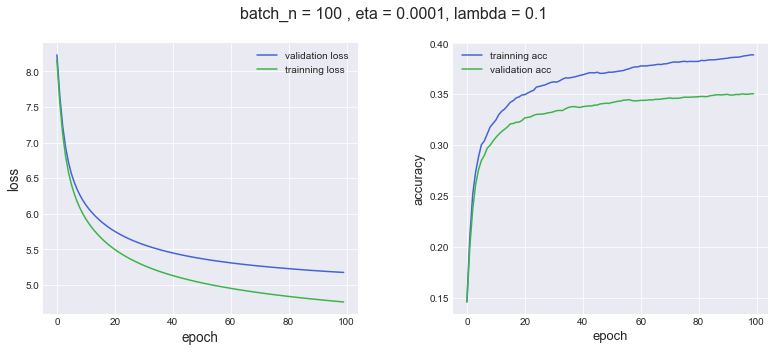

In [128]:
plot_validation_trainning_cf_acc(cf_val_s, cf_train_s, acc_train_s, acc_val_s, GD_params_s,lambda_=1e-05,
                                 out_filename='none')

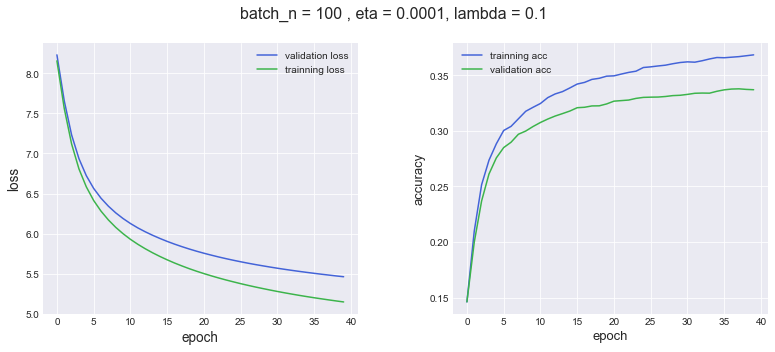

In [115]:
plot_validation_trainning_cf_acc(cf_val_s, cf_train_s, acc_train_s, acc_val_s, GD_params_s,lambda_=0.1,
                                 out_filename='none')

In [125]:
GD_params_s = params(50, 0.00001, 200)
W_s, cf_train_s, cf_val_s, acc_train_s, acc_val_s = MiniBatch_SVM(
    transf_trainning_data, transf_validation_data, trainning_data.y, validation_data.y,
    GD_params_s, transf_W, lambda_=0.001
)


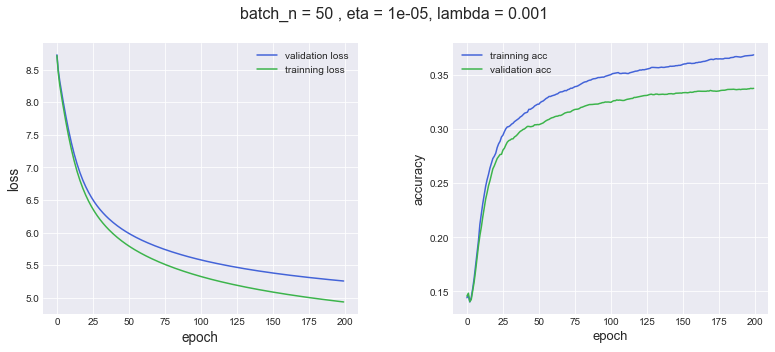

In [126]:
plot_validation_trainning_cf_acc(cf_val_s, cf_train_s, acc_train_s, acc_val_s, GD_params_s,lambda_=0.001,
                                 out_filename='none')

In [123]:
GD_params_s = params(100, 0.00001, 40)
W_s, cf_train_s, cf_val_s, acc_train_s, acc_val_s = MiniBatch_SVM(
    transf_trainning_data, transf_validation_data, trainning_data.y, validation_data.y,
    GD_params_s, transf_W, lambda_=0.001
)


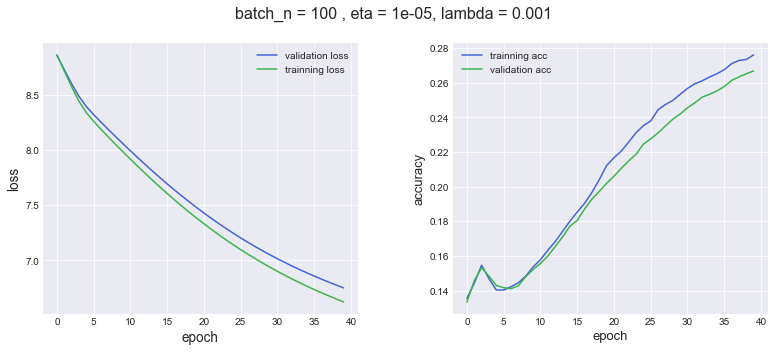

In [124]:
plot_validation_trainning_cf_acc(cf_val_s, cf_train_s, acc_train_s, acc_val_s, GD_params_s,lambda_=0.001,
                                 out_filename='none')

In [121]:
GD_params_s = params(100, 0.001, 40)
W_s, cf_train_s, cf_val_s, acc_train_s, acc_val_s = MiniBatch_SVM(
    transf_trainning_data, transf_validation_data, trainning_data.y, validation_data.y,
    GD_params_s, transf_W, lambda_=1
)


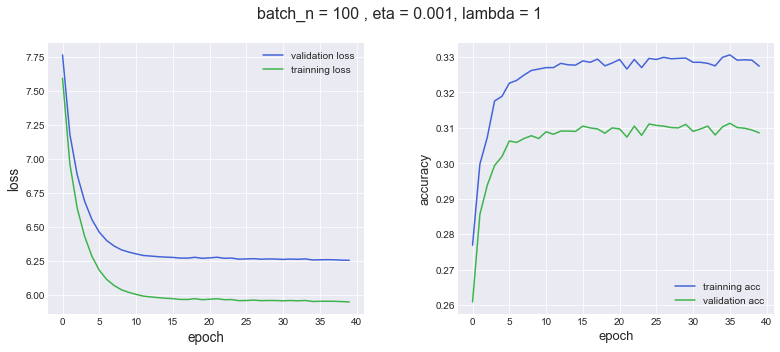

In [122]:
plot_validation_trainning_cf_acc(cf_val_s, cf_train_s, acc_train_s, acc_val_s, GD_params_s,lambda_=1,
                                 out_filename='none')

In [116]:
GD_params_s = params(100, 0.01, 40)
W_s, cf_train_s, cf_val_s, acc_train_s, acc_val_s = MiniBatch_SVM(
    transf_trainning_data, transf_validation_data, trainning_data.y, validation_data.y,
    GD_params_s, transf_W, lambda_=1
)


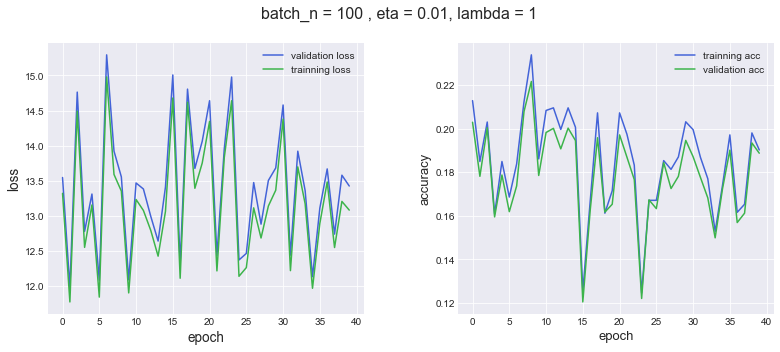

In [118]:
plot_validation_trainning_cf_acc(cf_val_s, cf_train_s, acc_train_s, acc_val_s, GD_params_s,lambda_=1,
                                 out_filename='none')

In [103]:
GD_params_s = params(100, 0.01, 40)
W_s, cf_train_s, cf_val_s, acc_train_s, acc_val_s = MiniBatch_SVM(transf_trainning_data, transf_validation_data, trainning_data.y, validation_data.y, GD_params_s,transf_W,lambda_=40)


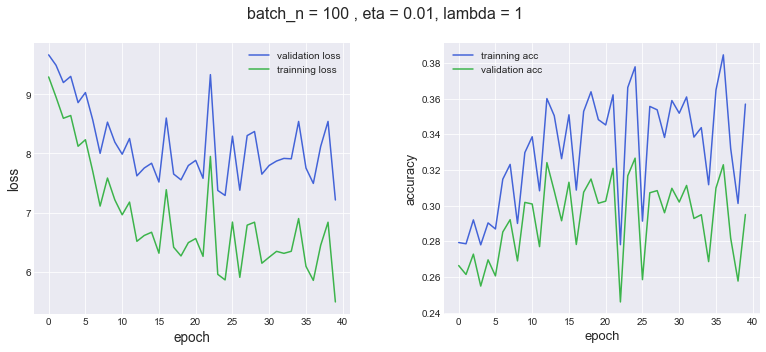

In [105]:
plot_validation_trainning_cf_acc(cf_val_s, cf_train_s, acc_train_s, acc_val_s, GD_params_s,lambda_=1,
                                 out_filename='none')

In [11]:
path = '/Users/user/Desktop/MSM/09-Deep Learning - KTH/assignments/assignment-1/Datasets/cifar-10-batches-py'
result_pics = '/Users/user/Desktop/MSM/09-Deep Learning - KTH/assignments/assignment-1/Result_Pics'

In [12]:
#Load Data:
trainning_data = LoadBatch(os.path.join(path,'data_batch_1'))
validation_data = LoadBatch(os.path.join(path,'data_batch_2'))
test_data = LoadBatch(os.path.join(path,'test_batch'))
mu, sigma = 0, 0.01

## Optimize the performance of the network:

### (g) Shuffle the order of your trainning examples at the beggining of every nth epoch.

In [15]:
W, b = w_b_random_initiation(trainning_data.data, trainning_data.labels, mu, sigma)

In [16]:
GD_params = params(100, 0.1, 40)
W_star, b_star, cf_train_, cf_val_, acc_train_, acc_val_ = MiniBatchGD_shuffled(
                                                            trainning_data.data,
                                                            validation_data.data,
                                                            trainning_data.labels,
                                                            trainning_data.y,
                                                            validation_data.labels,
                                                            validation_data.y,
                                                            GD_params,
                                                            W,
                                                            b,
                                                            lambda_=0
                                                            )

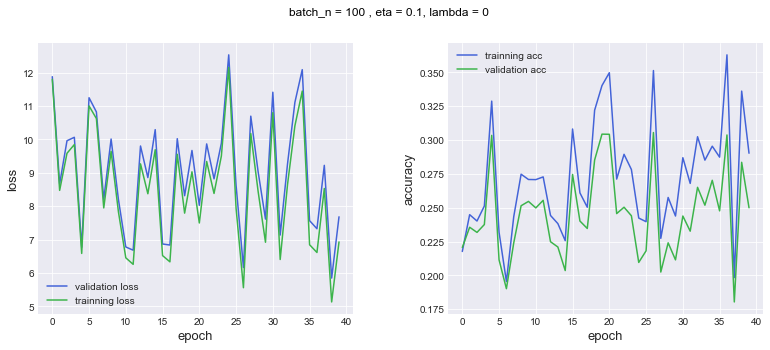

In [17]:
plot_validation_trainning_cf_acc(cf_val_, cf_train_, acc_train_, acc_val_, GD_params,lambda_=0,
                                 out_filename=os.path.join(result_pics,'lamda_0_eta_01_shuffled'))

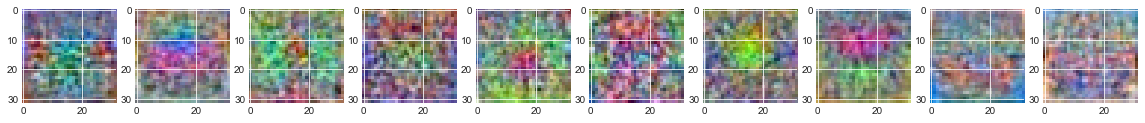

In [18]:
display_class_template_image(W_star, out_filename=os.path.join(result_pics,'lamda_0_eta_01_ct_shuffled'))

In [84]:
GD_params =  params(200, 0.0001, 50)
W_star, cf_train_, cf_val_, cl_train, cl_val, acc_train_, acc_val_ = MiniBatch_SVM(
                                                            trainning_data.data,
                                                            test_data.data,
                                                            trainning_data.y,
                                                            test_data.y,
                                                            GD_params,
                                                            W,
                                                            lambda_=0.001
                                                            )



In [ ]:
plot_validation_trainning_cf_acc(cf_val_a, cf_train_a, acc_train_a, acc_val_a, cl_train_a, cl_val_a, GD_params_a,lambda_=0,
                                 out_filename=os.path.join(result_pics,'lamda_0_eta_01'))


In [79]:
print(max(acc_val_))

0.2939


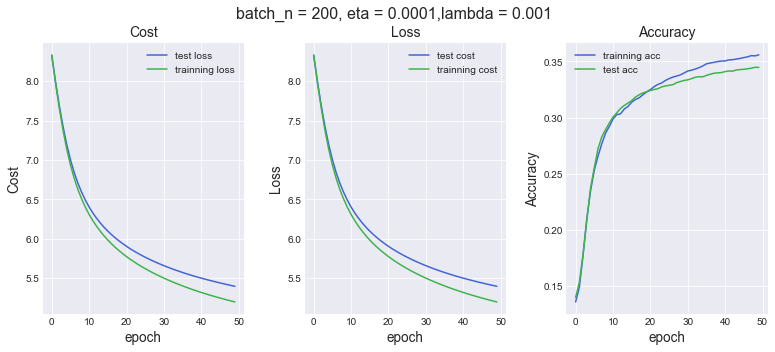

In [85]:
plot_validation_trainning_cf_acc(cf_val_, cf_train_, acc_train_, acc_val_, cl_train, cl_val, GD_params, lambda_=0.001,
                                 out_filename=os.path.join(result_pics,'svm4'))




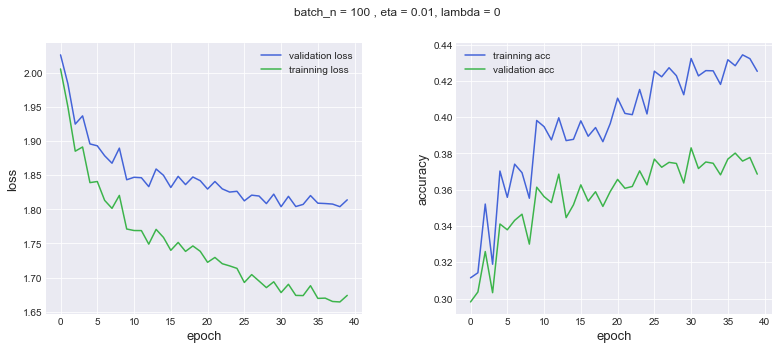

In [20]:
plot_validation_trainning_cf_acc(cf_val_, cf_train_, acc_train_, acc_val_, GD_params,lambda_=0,
                                 out_filename=os.path.join(result_pics,'lamda_0_eta_001_shuffled'))

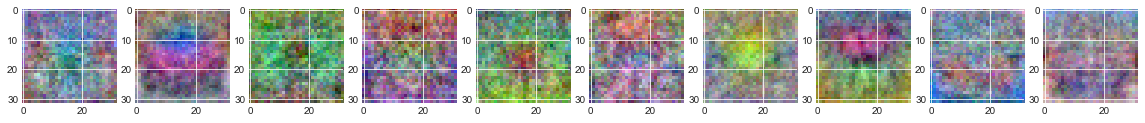

In [21]:
display_class_template_image(W_star, out_filename=os.path.join(result_pics,'lamda_0_eta_001_ct_shuffled'))

In [22]:
GD_params = params(100, 0.01, 40)
W_star, b_star, cf_train_, cf_val_, acc_train_, acc_val_ = MiniBatchGD_shuffled(
                                                            trainning_data.data,
                                                            validation_data.data,
                                                            trainning_data.labels,
                                                            trainning_data.y,
                                                            validation_data.labels,
                                                            validation_data.y,
                                                            GD_params,
                                                            W,
                                                            b,
                                                            lambda_=0.1
                                                            )

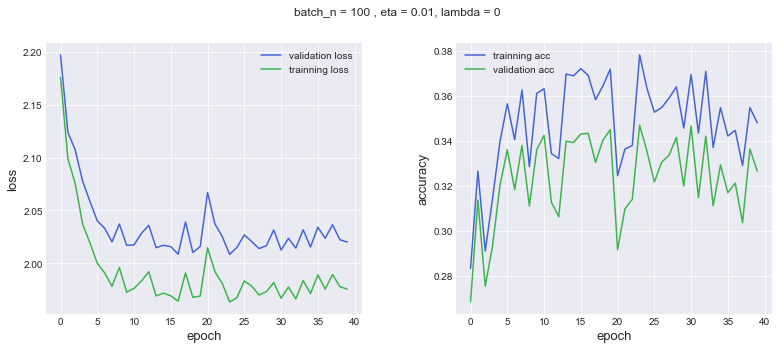

In [23]:
plot_validation_trainning_cf_acc(cf_val_, cf_train_, acc_train_, acc_val_, GD_params,lambda_=0.1,
                                 out_filename=os.path.join(result_pics,'lamda_01_eta_001_shuffled'))

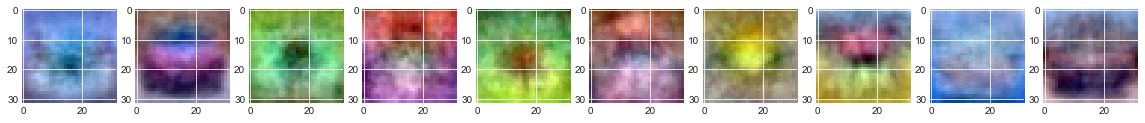

In [24]:
display_class_template_image(W_star, out_filename=os.path.join(result_pics,'lamda_01_eta_001_ct_shuffled'))

In [25]:
GD_params = params(100, 0.01, 40)
W_star, b_star, cf_train_, cf_val_, acc_train_, acc_val_ = MiniBatchGD_shuffled(
                                                            trainning_data.data,
                                                            validation_data.data,
                                                            trainning_data.labels,
                                                            trainning_data.y,
                                                            validation_data.labels,
                                                            validation_data.y,
                                                            GD_params,
                                                            W,
                                                            b,
                                                            lambda_=1
                                                            )

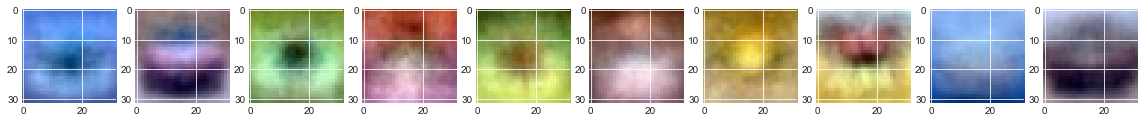

In [27]:
display_class_template_image(W_star, out_filename=os.path.join(result_pics,'lamda_1_eta_001_shuffled'))